Position Encoding
================================

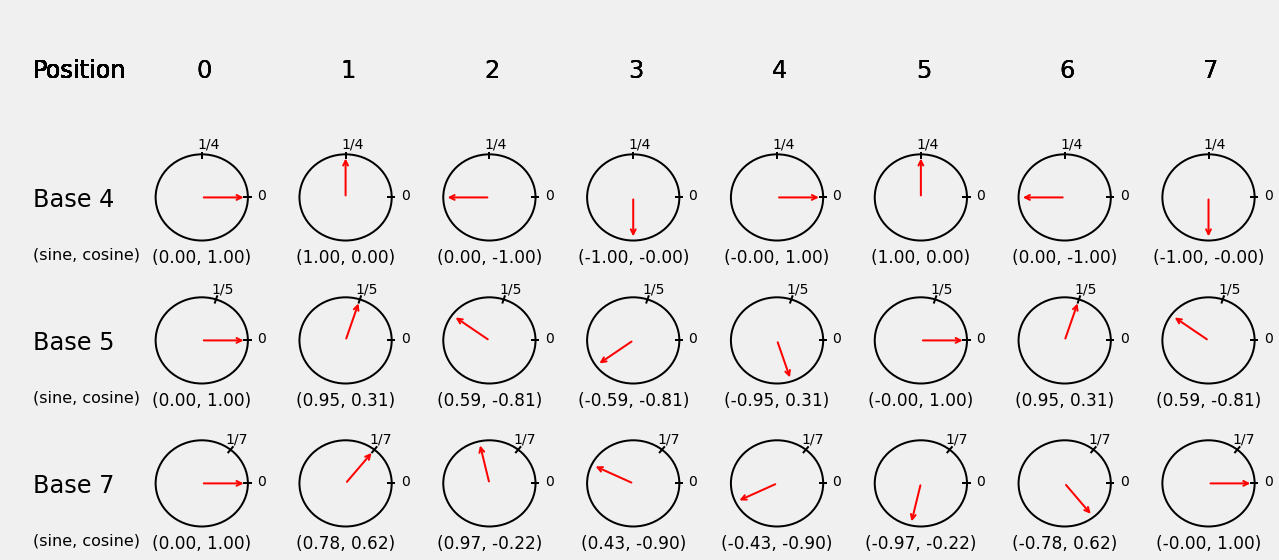

In [ ]:
fig = encoding_degrees(dims=3, seqs=(4, 5, 7), tot=8)

![](images/posenc_modnorm_sincos.png)

![](images/sincos_distance.png)

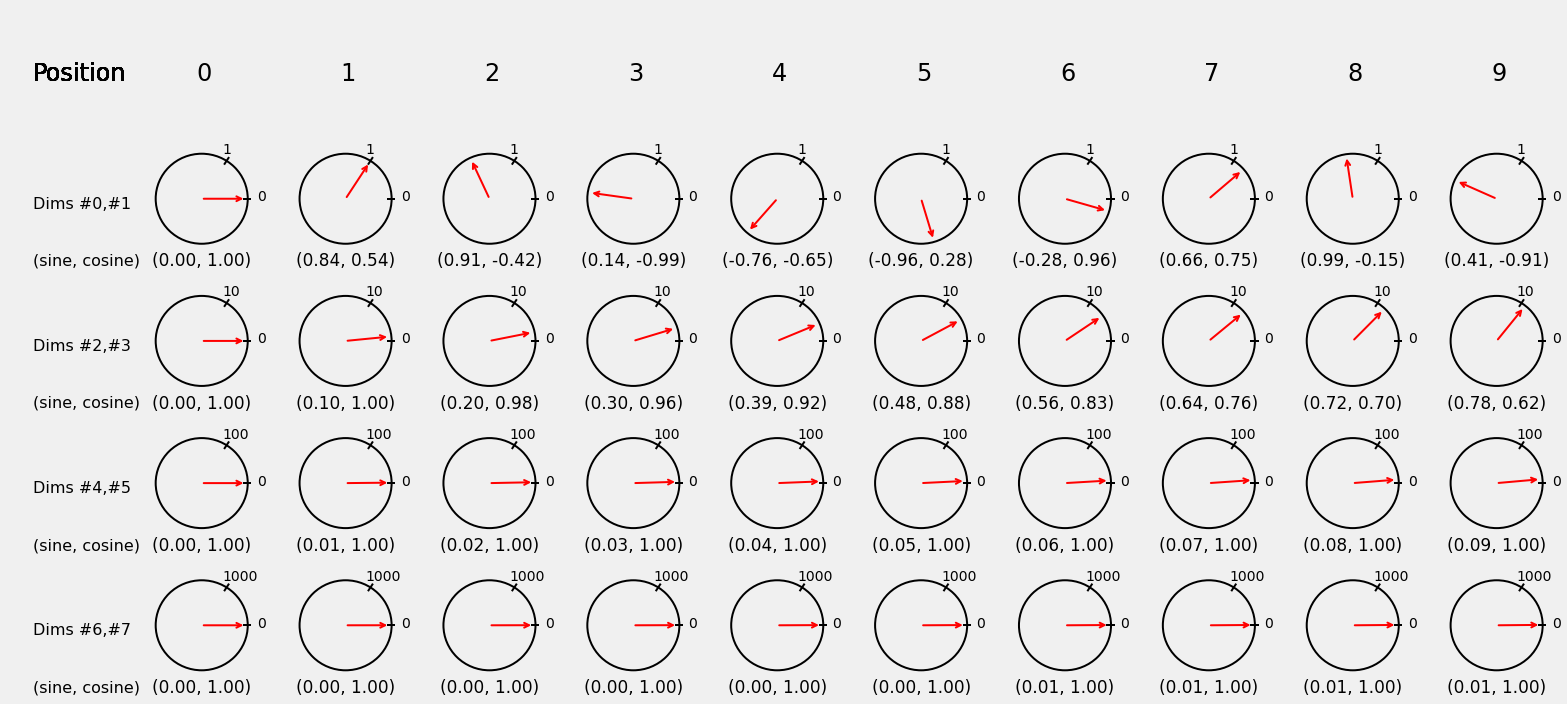

In [ ]:
fig = exponential_dials(d_model=8, max_len=10)

$$
\Large
\left(\frac{1}{10000^{\frac{0}{8}}}, \frac{1}{10000^{\frac{2}{8}}}, \frac{1}{10000^{\frac{4}{8}}}, \frac{1}{10000^{\frac{6}{8}}}\right)=(1, 0.1, 0.01, 0.001)
$$

$$
\Large
PE_{pos,\ 2d} = sin \left(\frac{1}{10000^{\frac{2d}{d_{model}}}}pos\right); PE_{pos,\ 2d+1} = cos \left(\frac{1}{10000^{\frac{2d}{d_{model}}}}pos\right)
$$

In [ ]:
max_len = 10
d_model = 8

position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

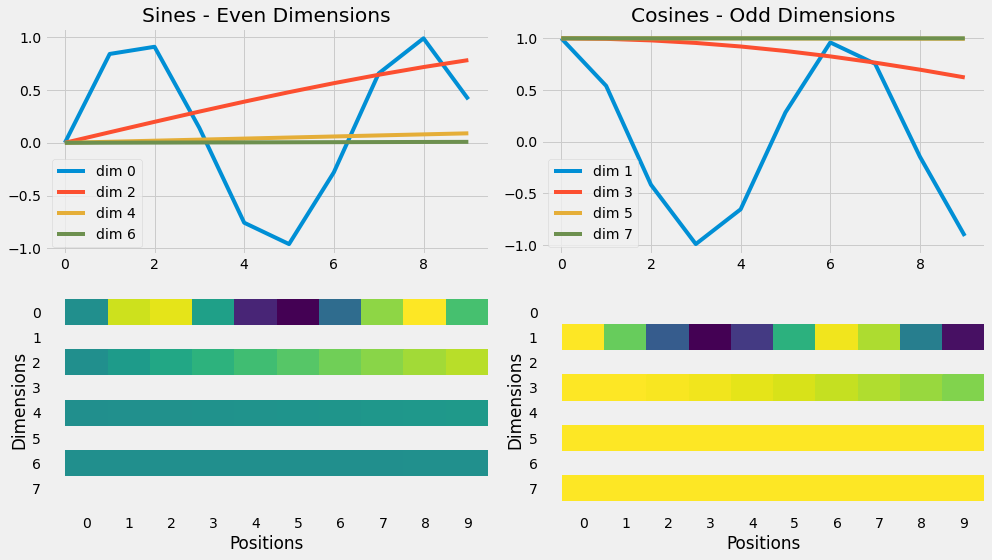

In [ ]:
fig = encoding_heatmap(d_model=8, max_len=10)

In [ ]:
np.round(encoding[0:4], 4) # first four positions

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])

### A Note on Encoded Distances

In [ ]:
distances = np.zeros((5, 5))
for i, v1 in enumerate(encoding[:5]):
    for j, v2 in enumerate(encoding[:5]):
        distances[i, j] = np.linalg.norm(v1 - v2)

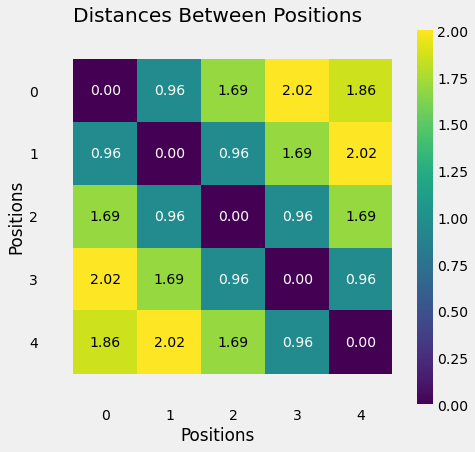

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title('Distances Between Positions')
fig = plot_mesh(distances, ax, showvals=True, colorbar=True, ylabel='Positions')

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

In [ ]:
posenc = PositionalEncoding(2, 2)

In [ ]:
list(posenc.parameters()), posenc.state_dict()

([],
 OrderedDict([('pe', tensor([[[0.0000, 1.0000],
                        [0.8415, 0.5403]]]))]))

In [ ]:
posenc.pe

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

In [ ]:
source_seq # 1, L, D

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [ ]:
source_seq + posenc.pe

tensor([[[-1.0000,  0.0000],
         [-0.1585,  1.5403]]])

$$
\Large
\text{standardized}\ x = \frac{\text{"raw"}\ x}{\sqrt{d_x}} \implies \text{"raw"} x = \sqrt{d_x}\ \text{standardized}\ x
$$

In [ ]:
posenc(source_seq)

tensor([[[-1.4142, -0.4142],
         [-0.5727,  1.9545]]])

### Encoder + Decoder + PE

In [ ]:
class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### Model Configuration & Training

In [ ]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

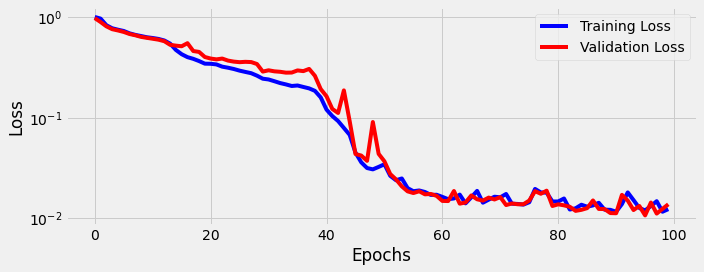

In [ ]:
fig = sbs_seq_selfattnpe.plot_losses()

### Visualizing Predictions

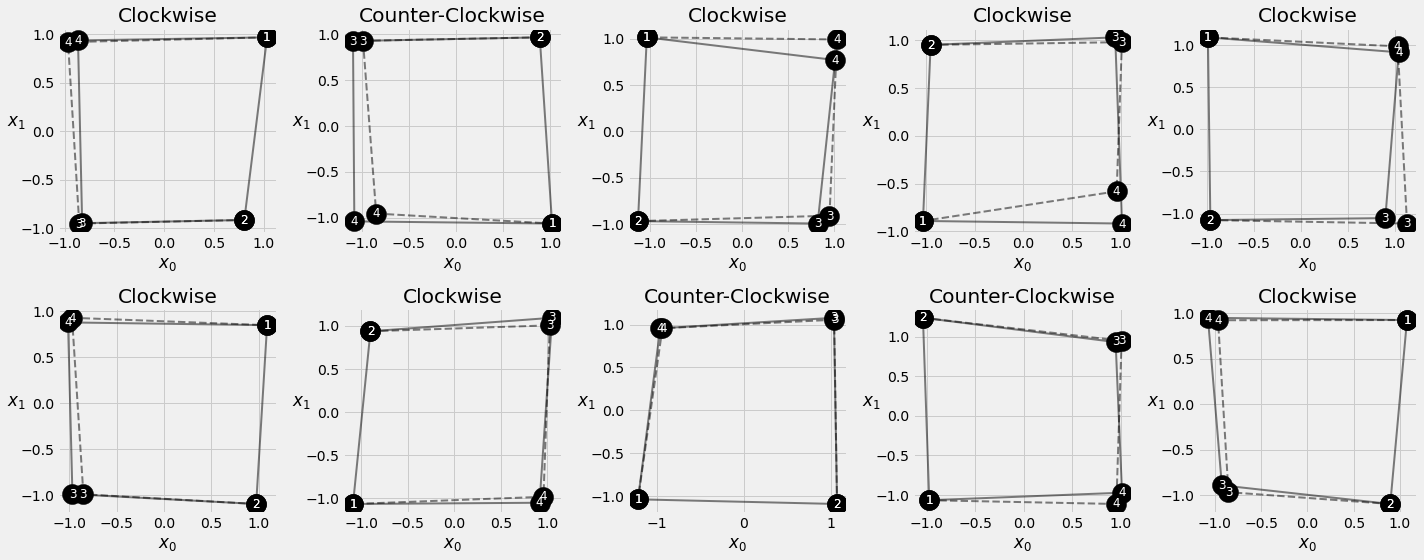

In [ ]:
fig = sequence_pred(sbs_seq_selfattnpe, full_test, test_directions)

### Visualizing Attention

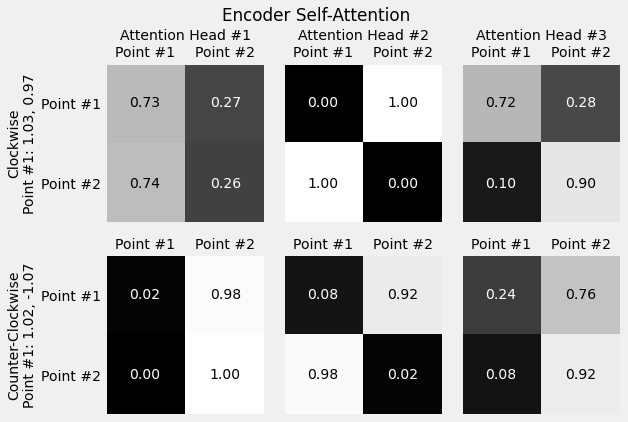

In [ ]:
inputs = full_test[:2, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]

fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, decoder=False, self_attn=True, alphas_attr='encoder.layer.self_attn_heads.alphas')
fig.suptitle('Encoder Self-Attention')
fig.subplots_adjust(top=0.85) 

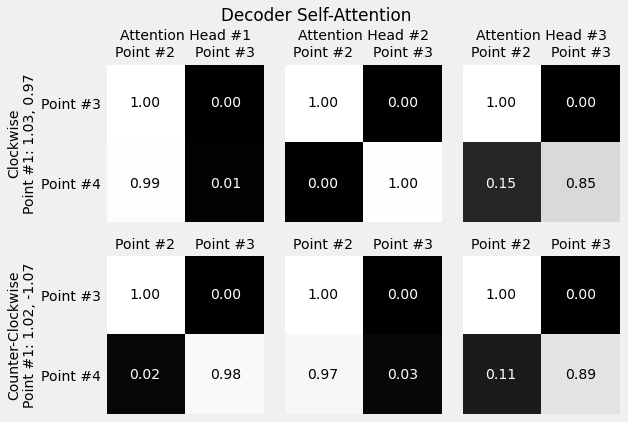

In [ ]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, 
                     decoder=True, self_attn=True, alphas_attr='decoder.layer.self_attn_heads.alphas')
fig.suptitle('Decoder Self-Attention')
fig.subplots_adjust(top=0.85) 

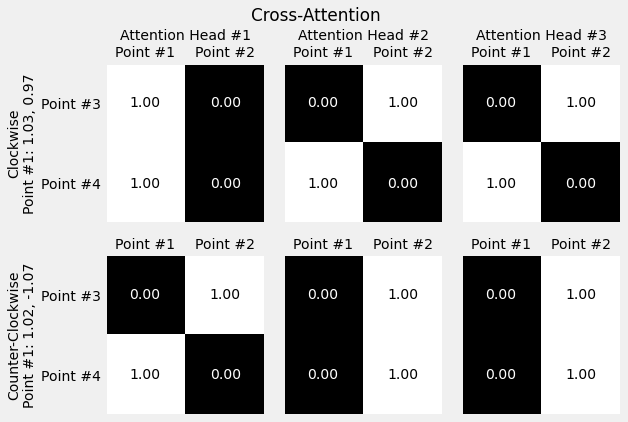

In [ ]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, self_attn=False, alphas_attr='decoder.layer.cross_attn_heads.alphas')
fig.suptitle('Cross-Attention')
fig.subplots_adjust(top=0.85) 

## Putting It All Together

### Data Preparation

In [ ]:
# Training set
points, directions = generate_sequences()
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

### Model Assembly

In [ ]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Encoder + Decoder + Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### Self-Attention "Layers"

In [ ]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

### Attention Heads

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out
    
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### Model Configuration & Training

In [ ]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

In [ ]:
sbs_seq_selfattnpe.losses[-1], sbs_seq_selfattnpe.val_losses[-1]

(0.01233051170129329, 0.013784115784801543)